# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

### Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

## План по выполнению проекта

Загрузить и подготовить данные. 

Провести EDA.

Обучить и проверить модель для каждого региона:
- Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучить модель и сделать предсказания на валидационной выборке.
- Сохранить предсказания и правильные ответы на валидационной выборке.
- Напечатать на экране средний запас предсказанного сырья и RMSE модели.
- Проанализировать результаты.

Подготовиться к расчёту прибыли:
- Все ключевые значения для расчётов сохранить в отдельных переменных.
- Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
- Напишисать выводы по этапу подготовки расчёта прибыли.

Разработать функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выбрать скважины с максимальными значениями предсказаний.
- Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитать прибыль для полученного объёма сырья.

Посчитать риски и прибыль для каждого региона:
- Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Сформулировать выводы: предложить регион для разработки скважин и обосновать свой выбор.

## Загрузка и подготовка данных

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:
- /datasets/geo_data_0.csv. 
- /datasets/geo_data_1.csv. 
- /datasets/geo_data_2.csv.

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

In [1]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from tqdm import tqdm_notebook

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# читаем данные
local=False
if local: 
    geo_0 = pd.read_csv('./datasets/geo_data_0.csv')
    geo_1 = pd.read_csv('./datasets/geo_data_1.csv')
    geo_2 = pd.read_csv('./datasets/geo_data_2.csv')
else: #работа лакально
    url = "https://drive.google.com/file/d/1L_Q_SfrXnSVU3Ks-SbRPvNDHn252c3vg/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    geo_0 = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/1PTNmVmc7nQXOa2bTpafZPSR9u5hOIj6h/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    geo_1 = pd.read_csv(path)
    
    url = "https://drive.google.com/file/d/16rO94zFwfhIyCERM7etliPeGG_nacBQ6/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    geo_2 = pd.read_csv(path)

In [4]:
geo_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
sum(geo_0.duplicated())

0

In [6]:
geo_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [9]:
geo_1[geo_1['id'].duplicated()].sort_values(by ='id')

,id,f0,f1,f2,product
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [10]:
geo_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
geo_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [12]:
geo_2[geo_2['id'].duplicated()]

,id,f0,f1,f2,product
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


**Вывод: Пропусков нет. Данные прочитаны.**

### Проведем предварительный анализ (EDA)

**Регион GEO_0**

In [13]:
geo_0.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


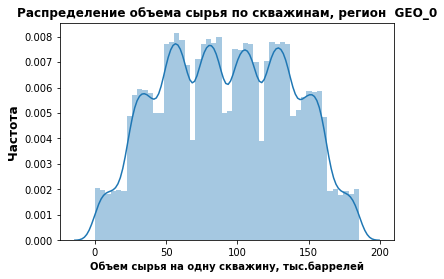

In [14]:
sns.distplot(geo_0['product']);
plt.xlabel('Объем сырья на одну скважину, тыс.баррелей',fontsize=10, weight = 'bold')
plt.ylabel('Частота',fontsize=12, weight = 'bold')
plt.title("Распределение объема сырья по скважинам, регион  GEO_0",fontsize=12, weight = 'bold');

**Регион GEO_1**

In [15]:
geo_1.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


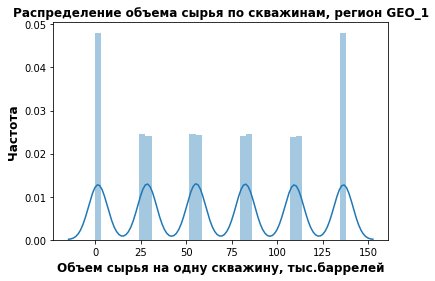

In [16]:
sns.distplot(geo_1['product']);
plt.xlabel('Объем сырья на одну скважину, тыс.баррелей',fontsize=12, weight = 'bold')
plt.ylabel('Частота',fontsize=12, weight = 'bold')
plt.title("Распределение объема сырья по скважинам, регион GEO_1",fontsize=12, weight = 'bold');

**Регион GEO_2**

In [17]:
geo_2.describe().T

,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


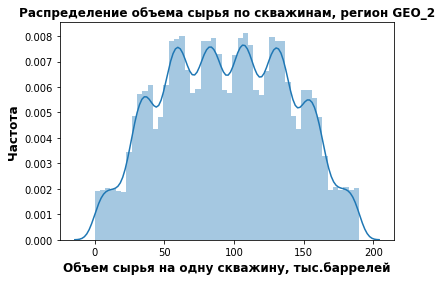

In [18]:
sns.distplot(geo_2['product']);
plt.xlabel('Объем сырья на одну скважину, тыс.баррелей',fontsize=12, weight = 'bold')
plt.ylabel('Частота',fontsize=12, weight = 'bold')
plt.title("Распределение объема сырья по скважинам, регион GEO_2",fontsize=12, weight = 'bold');

Соберем общий датасет с разбивкой по регионам.

In [19]:
geo_0['geo'] = 'geo_0'
geo_1['geo'] = 'geo_1'
geo_2['geo'] = 'geo_2'

In [20]:
all_region = pd.concat([geo_0,geo_1,geo_2]).reset_index()
all_region.sample(5,random_state = 12345)

,index,id,f0,f1,f2,product,geo
162081,62081,9wOvu,7.043258,-22.539202,5.004679,134.766305,geo_1
99210,99210,kGhkV,0.272867,-0.264304,2.785357,130.372036,geo_0
12892,12892,En98K,1.315542,-0.611874,4.080003,139.853405,geo_0
5649,5649,Zh8eR,0.084526,0.122532,-0.613650,142.582471,geo_0
240775,40775,Rgzqf,2.617988,0.158650,5.370269,117.778531,geo_2


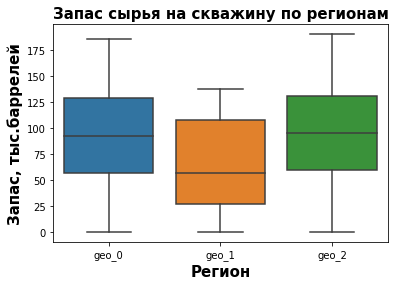

In [21]:
# визуализируем запасы сырья на одну скважину
sns.boxplot(x=all_region['geo'], y=all_region['product']);
plt.title("Запас сырья на скважину по регионам",fontsize=15, weight = 'bold');
plt.ylabel('Запас, тыс.баррелей',fontsize=15, weight = 'bold')
plt.xlabel('Регион',fontsize=15, weight = 'bold');

**Вывод: Предварительно, регион GEO_1 выглядит, как наиболее бедный на фоне регионов GEO_0 и GEO_2.  Возможно, предпочтении следует отдать региону GEO_2 с наибольшим медианным значением по запасам на скважину = 94.92 тыс.баррелей. В регионе GEO_2 медиана = 91.84 тыс.баррелей на одну скважину. В регионе GEO_1 медиана = 57.08 тыс.баррелей**

**Суммарный запас всего сырья по регионам**


In [22]:
print('Регион GEO_0. Суммарный объем запасов {:,.2f} тыс.баррелей'.format(geo_0['product'].sum()))
print('Регион GEO_1. Суммарный объем запасов {:,.2f} тыс.баррелей'.format(geo_1['product'].sum()))
print('Регион GEO_2. Суммарный объем запасов {:,.2f} тыс.баррелей'.format(geo_2['product'].sum()))

Регион GEO_0. Суммарный объем запасов 9,250,000.00 тыс.баррелей
Регион GEO_1. Суммарный объем запасов 6,882,500.00 тыс.баррелей
Регион GEO_2. Суммарный объем запасов 9,500,000.00 тыс.баррелей


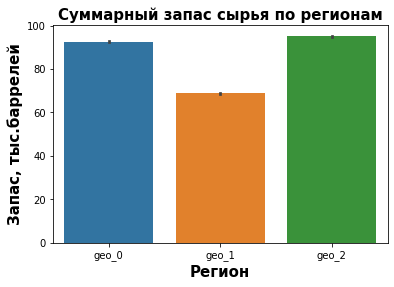

In [23]:
sns.barplot(x='geo', y='product', data=all_region)
plt.title("Суммарный запас сырья по регионам",fontsize=15, weight = 'bold');
plt.ylabel('Запас, тыс.баррелей',fontsize=15, weight = 'bold')
plt.xlabel('Регион',fontsize=15, weight = 'bold');

**Вывод: По суммарному запасу сырья регион GEO_1 проигрывает региону GEO_0 и GEO_2**

- **Регион GEO_0. Суммарный объем запасов 9,250,000.00 тыс.баррелей**
- **Регион GEO_1. Суммарный объем запасов 6,882,500.00 тыс.баррелей**
- **Регион GEO_2. Суммарный объем запасов 9,500,000.00 тыс.баррелей**


## Обучение и проверка модели

#### Посмотрим на корреляции между признаками по каждому датасет регионов.

In [24]:
geo_0_corr = geo_0.corr()
# geo_0_corr
# geo_0_corr.style.background_gradient('coolwarm')

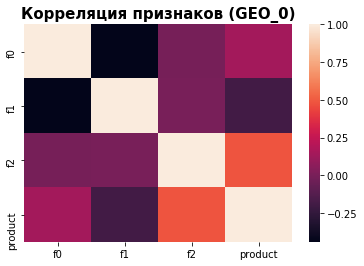

In [25]:
sns.heatmap(geo_0_corr);
plt.title("Корреляция признаков (GEO_0)", fontsize=15, weight = 'bold');

**Вывод: В регионе №0 Признаки f0 и f1 имеют между собой незначительную отрицательную корреляцию = -0.44. Целевой признак product коррелирует с признаком f2 (0.48).**

In [26]:
geo_1_corr = geo_1.corr()
# geo_1_corr
# geo_1_corr.style.background_gradient('coolwarm')

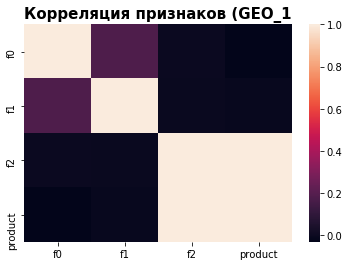

In [27]:
sns.heatmap(geo_1_corr);
plt.title("Корреляция признаков (GEO_1", fontsize=15, weight = 'bold');

**Вывод: В регионе №1 признаки f0, f1 и f2 между собой не коррелируют. Целевой признак product сильно коррелирует с признаком f2 (0.99).**

In [28]:
geo_2_corr = geo_2.corr()
# geo_2_corr
# geo_2_corr.style.background_gradient('coolwarm')

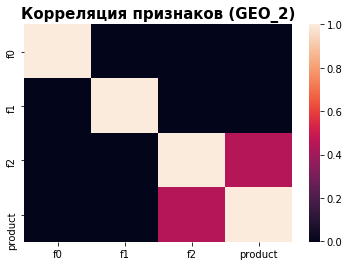

In [29]:
sns.heatmap(geo_2_corr);
plt.title("Корреляция признаков (GEO_2)", fontsize=15, weight = 'bold');

**Вывод: В регионе №2 признаки f0, f1 и f2 между собой не коррелируют. Целевой признак product коррелирует с признаком f2 (0.4).**

**Вывод: Мультиколлиенарных признаков - нет. Целевой признак product коррелирует с f2.**

#### Уберем не нужные для обучения моделей признаки.

In [30]:
geo_0.drop(['id', 'geo'], axis=1, inplace=True)
geo_1.drop(['id', 'geo'], axis=1, inplace=True)
geo_2.drop(['id', 'geo'], axis=1, inplace=True)

In [31]:
# проверим
geo_0.head(1)

,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


#### Линейная модель чувствительна к выбросам, уберем экстремальные значения, если они есть за пределами межквартильного размаха.

In [32]:
# функция возвращает межквартильный размах для колонки датафрейма в виде кортежа
def generate_range(df, column):   
    Q25 = df[column].quantile(0.25)                 
    Q75 = df[column].quantile(0.75) 
    MIN = df[column].min()
    MAX = df[column].max()  
    IQR = Q75 - Q25    
    left = Q25 - 1.5*IQR
    if left < MIN: left = MIN    
    Right = Q75 + 1.5*IQR
    if Right > MAX: Right = MAX     
    return (left, Right)

# функция обрезает датафрейм по IRQ в колонке
def df_IRQ(df, column):
    column = 'product'
    tuple_range = generate_range(df, column)
    left_range = tuple_range[0]
    right_range = tuple_range[1]
    sql_sentence='@left_range <= '+ column + ' and '+ column + ' <= @right_range'
    df_temp = df.query(sql_sentence)
    df = df_temp.copy()
    del df_temp


In [33]:
# пытаемся убрать выбросы
df_IRQ(geo_1, 'product')
df_IRQ(geo_2, 'product')
df_IRQ(geo_0, 'product')

In [34]:
# оценим новые размеры датафреймов
print(len(geo_0))
print(len(geo_1))
print(len(geo_2))

100000
100000
100000


**Вывод: Размеры датафреймов остались прежними - значит выбросов нет.**

### Напишем функцию для обучения моделей 

In [35]:
def geo_fit_predict(df):
    
    y = df['product'].copy()
    X = df.drop('product', axis=1).copy()

    # отделим 25% данных для валидационной + обучающейq выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=12345)
    
    model = LinearRegression()

    model.fit(X_train, y_train)
    predicted_valid = model.predict(X_valid)
    
    MSE = mean_squared_error(y_valid, predicted_valid)
    RMSE = MSE**0.5
    
    # средний запас предсказанного сырья - average_stock_of_predicted_product
    aspp = predicted_valid.mean()
    
    result_parameters = {'y_valid':y_valid, 'predicted_valid':predicted_valid, 'RMSE':RMSE, 'aspp': aspp}
  
    return model, result_parameters

### Применим модель последовательно к каждому из регионов

### Регион GEO_0

In [36]:
model_0, p_0 = geo_fit_predict(geo_0)
print('Регион 0. Средний запас предсказанного сырья = {:.2f}, RMSE = {:.2f}'.format(p_0['aspp'],p_0['RMSE']))

Регион 0. Средний запас предсказанного сырья = 92.59, RMSE = 37.58


### Регион GEO_1

In [37]:
model_1, p_1 = geo_fit_predict(geo_1)
print('Регион 1. Средний запас предсказанного сырья = {:.2f}, RMSE = {:.2f}'.format(p_1['aspp'],p_1['RMSE']))

Регион 1. Средний запас предсказанного сырья = 68.73, RMSE = 0.89


### Регион GEO_2

In [38]:
model_2, p_2, = geo_fit_predict(geo_2)
print('Регион 2. Средний запас предсказанного сырья = {:.2f}, RMSE = {:.2f}'.format(p_2['aspp'],p_2['RMSE']))

Регион 2. Средний запас предсказанного сырья = 94.97, RMSE = 40.03


**Вывод: В регионах №0 и №1 средний запас предсказанного сырья на одну скважину находится в пределах 92-94 тыс. баррелей. При этом ошибка +/- может составить до 40 тыс.баррелей.  Регион №1 имеет несколько более низкий средний запас сырья на скважину - 68 тыс. баррелей, но при этом ошибка предсказания запасов крайне мала и равна 0.89 тыс. баррелей.**

## Подготовка к расчёту прибыли

Все ключевые значения для расчётов сохраним в отдельных переменных.

In [39]:
# Бюджет на разработку скважин в регионе = 10 млрд рублей
BUDGET_PER_REGION = 10 * 10**9

# Доход с каждой единицы продукта составляет 450 тыс. рублей
INCOME_PER_UNIT_OF_PRODUCT = 450000

# При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
NUMBER_OF_BOREHOLES = 200   

# Бюджет на одну скважину
BUDGET_PER_BOREHOLES = BUDGET_PER_REGION / NUMBER_OF_BOREHOLES
print('Бюджет на 1 скважину = {:,} руб.'.format(BUDGET_PER_BOREHOLES))

# пороговое значение количества сырья в одной скважине
TRESHOLD_PRODUCT = BUDGET_PER_BOREHOLES / INCOME_PER_UNIT_OF_PRODUCT
print('Пороговое значение количества сырья в скважине = {:.2f} тыс.баррелей'.format(TRESHOLD_PRODUCT))

Бюджет на 1 скважину = 50,000,000.0 руб.
Пороговое значение количества сырья в скважине = 111.11 тыс.баррелей


Посмотрим соотношение убыточных скважин по регионам, это скважины - в которых запас сырья меньше порогового значения 111.11 тыс.баррелей.

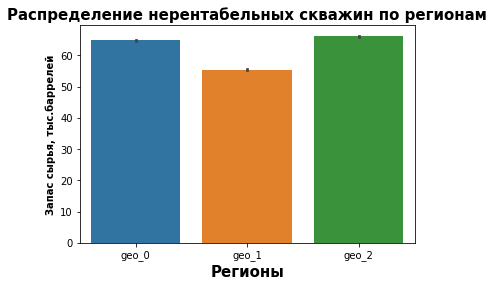

In [40]:
df_threshold = all_region.query('product < @TRESHOLD_PRODUCT')
sns.barplot(x='geo', y='product', data=df_threshold) 
plt.title("Распределение нерентабельных скважин по регионам",fontsize=15, weight = 'bold');
plt.xlabel('Регионы',fontsize=15, weight = 'bold')
plt.ylabel('Запас сырья, тыс.баррелей',fontsize=10, weight = 'bold');

**Вывод: В регионе GEO_1 меньшее количество запасов сосредоточены в убыточных скважинах, чем в регионах GEO_0 и GEO_2!**

**А это в свою очередь, говорит о том, что при выборе скважиин для промышленной разработки, меньше шансов попасть на убыточные скважины.**

**Вывод: Для безубыточной работы необходимо иметь на одну скважину средний запас не менее 111.11 тыс. баррелей. Предсказанные средние значения по регионам (92, 68, 94) меньше этотого порога для всех трех регионов.**

## Разработка функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:

In [41]:
state = np.random.RandomState(12345)

In [42]:
# функция для рандомного выбора 500 скважин и предсказания в этих скважинах количества сырья
def predict_500(df, model):
    subsample_500 = df.sample(500, replace=True, random_state=state)
    X = subsample_500.drop('product', axis=1)
    predict_500 = model.predict(X)
    subsample_500['predict'] = predict_500
    return subsample_500 

In [43]:
#функция расчета прибыли
def predict_profit(parameters):
    # собираем предсказанные и реальные значения на валидационной выборке
    df = pd.DataFrame({'y_valid':parameters['y_valid'], 'predicted_valid': parameters['predicted_valid']})
    # выбираем 500 случайных точек
    df_sample_500 = df.sample(500, random_state = state)
    # сортируем по убыванию и оставляем 200 лучших по предсказанию
    df_200 = df_sample_500.sort_values(by ='predicted_valid', ascending = False).head(200)
    # считаем доход
    df_200['income'] = df_200['y_valid'] * INCOME_PER_UNIT_OF_PRODUCT
    income = df_200['income'].sum()
    #считаем прибыль
    profit = income - BUDGET_PER_REGION
    return profit

Посмотрим работу функции на разных регионах

In [44]:
print('Регион GEO_0. Прибыль при разработке 200 скважин. {:,.0F} руб.'.format(predict_profit(p_0)))

Регион GEO_0. Прибыль при разработке 200 скважин. 679,068,858 руб.


In [45]:
print('Регион GEO_1. Прибыль при разработке 200 скважин. {:,.0F} руб.'.format(predict_profit(p_1)))

Регион GEO_1. Прибыль при разработке 200 скважин. 252,958,297 руб.


In [46]:
print('Регион GEO_2. Прибыль при разработке 200 скважин. {:,.0F} руб.'.format(predict_profit(p_2)))

Регион GEO_2. Прибыль при разработке 200 скважин. 491,868,504 руб.


Вывод: Функция для моделирования подготовлена.

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли и оценить риски.

In [47]:
state = np.random.RandomState(12345) 

In [48]:
def calculate_profit_and_confidence_interval(parameters):

    number_bootstrap = 1000
    values = []
    losing_money = 0
    for i in tqdm_notebook(range(number_bootstrap)):
        profit = predict_profit(parameters)
        values.append(profit)
        if profit < 0:
            losing_money += 1

    values = pd.Series(values)
    
    losing_money_probability = losing_money/number_bootstrap

    mean = values.mean()
    lower = values.quantile(0.250)
    upper = values.quantile(0.975) 

    print('Cредняя прибыль: {:,.0F} руб.'.format(mean))
    print('95% доверительный интервал ({:,.0F} - {:,.0F}) руб.'.format(lower,upper))
    print('Вероятность убытков {:.2%}'.format(losing_money_probability))


**Регион GEO_0**

In [49]:
calculate_profit_and_confidence_interval(p_0)


Cредняя прибыль: 380,710,891 руб.
95% доверительный интервал (193,754,348 - 879,613,968) руб.
Вероятность убытков 7.20%


**Регион GEO_1**

In [50]:
calculate_profit_and_confidence_interval(p_1)


Cредняя прибыль: 454,785,435 руб.
95% доверительный интервал (324,130,456 - 840,213,356) руб.
Вероятность убытков 1.30%


**Регион GEO_2**

In [51]:
calculate_profit_and_confidence_interval(p_2)


Cредняя прибыль: 389,217,074 руб.
95% доверительный интервал (209,420,567 - 906,512,590) руб.
Вероятность убытков 7.30%


## Выводы

Был проведен предварительный анализ данных (EDA), для выявления важных признаков которые помогут определить регион, где добыча принесёт наибольшую прибыль

Первоначально удалось установить, что по суммарному запасу сырья регион GEO_1 проигрывает региону GEO_0 и GEO_2
- Регион №0. Суммарный объем запасов 9,250,000.00 тыс.баррелей
- Регион №1. Суммарный объем запасов 6,882,500.00 тыс.баррелей
- Регион №2. Суммарный объем запасов 9,500,000.00 тыс.баррелей 

Однако, после того, как был установлен порог необходимого запаса сырья для безубыточной работы (равный 111 тыс.бареллей) выяснилось, что в регионе GEO_1, который казалось бы, обладает меньшими запасами, минимальное колличество сырья сосредоточено именно в убыточных скважинах. 

Была построена линейная регрессионная модель для предсказания запасов сырья. Технологией bootstrap было отобрано в каждом регионе 200 скважин имееющих наибольшие предсказанные запасы.

Расчитана прибыль и 95% доверительный прибыли по каждому региону:

GEO_0: 

- Cредняя прибыль: 380,710,891 руб.
- 95% доверительный интервал (193,754,348 - 879,613,968) руб.
- Вероятность убытков 7.20%

GEO_1: 

- Cредняя прибыль: 454,785,435 руб.
- 95% доверительный интервал (324,130,456 - 840,213,356) руб.
- Вероятность убытков 1.30%

GEO_2: 

- Cредняя прибыль: 389,217,074 руб.
- 95% доверительный интервал (209,420,567 - 906,512,590) руб.
- Вероятность убытков 7.30%



**К разработке следует рекомендовать регион GEO_1, так как прибыль по этому региону максимальна, при минимальном риске получения убытков.**